In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths
data_path = "../data/"  # Change this to your dataset directory
model_save_path = "../models/"
test_file = os.path.join(data_path, "test_data.csv")



C:\Users\Girija\Documents\GitHub\nlp-sentiment-suite\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def load_test_data(file_path):
    """
    Load the test dataset from the specified path.
    """
    df = pd.read_csv(file_path)

    # Handle missing values in 'clean_text' column
    df['clean_text'] = df['clean_text'].fillna('')  # Replace NaN with an empty string

    return df


# Load and prepare test data
test_df = load_test_data(test_file)
X_test = test_df['clean_text']
y_test = test_df['category']
print(f"Loaded test data with {test_df.shape[0]} rows.")



Loaded test data with 32595 rows.


In [3]:


def evaluate_model(y_true, y_pred, model_name):
    """
    Function to evaluate a model using standard metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()



Evaluating Logistic_Regression...

Logistic_Regression Evaluation Metrics:
Accuracy: 0.9144
F1-score: 0.9133
Precision: 0.9149
Recall: 0.9144

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.91      0.80      0.85      7102
         0.0       0.90      0.97      0.93     11043
         1.0       0.93      0.93      0.93     14450

    accuracy                           0.91     32595
   macro avg       0.91      0.90      0.90     32595
weighted avg       0.91      0.91      0.91     32595



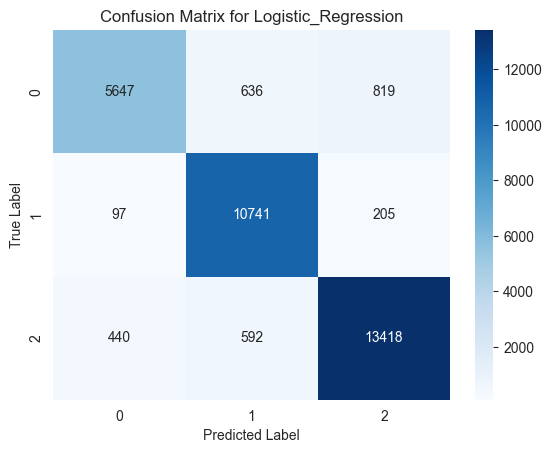

Evaluating Naive_Bayes...

Naive_Bayes Evaluation Metrics:
Accuracy: 0.7509
F1-score: 0.7421
Precision: 0.7736
Recall: 0.7509

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.85      0.48      0.61      7102
         0.0       0.84      0.71      0.77     11043
         1.0       0.69      0.92      0.79     14450

    accuracy                           0.75     32595
   macro avg       0.79      0.70      0.72     32595
weighted avg       0.77      0.75      0.74     32595



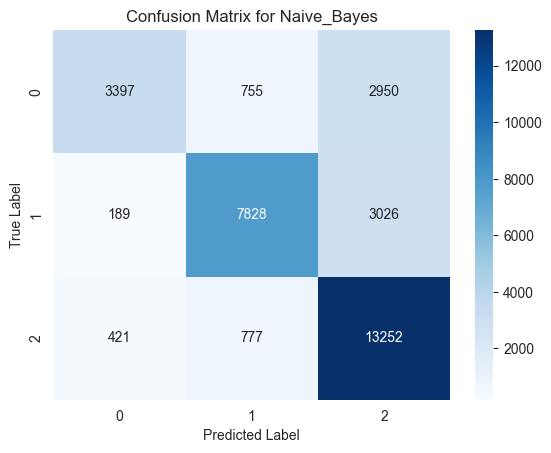

Evaluating SVM...

SVM Evaluation Metrics:
Accuracy: 0.9334
F1-score: 0.9327
Precision: 0.9329
Recall: 0.9334

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.91      0.85      0.88      7102
         0.0       0.94      0.98      0.96     11043
         1.0       0.94      0.94      0.94     14450

    accuracy                           0.93     32595
   macro avg       0.93      0.92      0.93     32595
weighted avg       0.93      0.93      0.93     32595



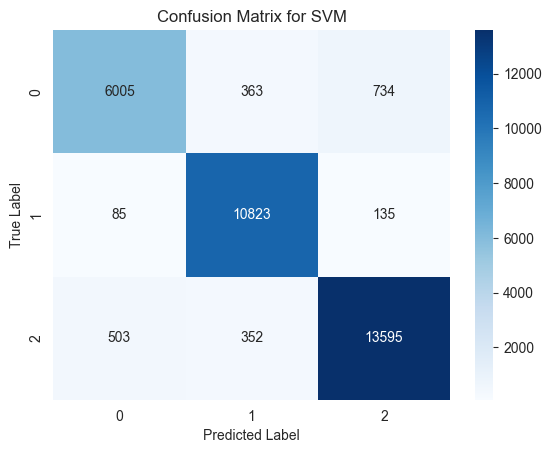

In [4]:

def evaluate_baseline_models(X_test, y_test):
    """
    Function to load and evaluate baseline models: Logistic Regression, Naive Bayes, and SVM.
    """
    baseline_models = ["Logistic_Regression.pkl", "Naive_Bayes.pkl", "SVM.pkl"]
    vectorizer_path = os.path.join(model_save_path, "tfidf_vectorizer.pkl")

    # Load the TF-IDF vectorizer
    if os.path.exists(vectorizer_path):
        vectorizer = joblib.load(vectorizer_path)
    else:
        print("TF-IDF Vectorizer not found!")
        return

    # Transform test data
    X_test_tfidf = vectorizer.transform(X_test)

    for model_file in baseline_models:
        model_path = os.path.join(model_save_path, model_file)
        if os.path.exists(model_path):
            print(f"Evaluating {model_file.replace('.pkl', '')}...")
            model = joblib.load(model_path)
            y_pred = model.predict(X_test_tfidf)
            evaluate_model(y_test, y_pred, model_file.replace(".pkl", ""))
        else:
            print(f"Model file {model_file} not found!")


evaluate_baseline_models(X_test, y_test)



C:\Users\Girija\AppData\Local\Temp\ipykernel_17908\2113101105.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(lstm_model_path))
C:


LSTM Model Evaluation Metrics:
Accuracy: 0.4433
F1-score: 0.2723
Precision: 0.1965
Recall: 0.4433

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7102
           1       0.00      0.00      0.00     11043
           2       0.44      1.00      0.61     14450

    accuracy                           0.44     32595
   macro avg       0.15      0.33      0.20     32595
weighted avg       0.20      0.44      0.27     32595



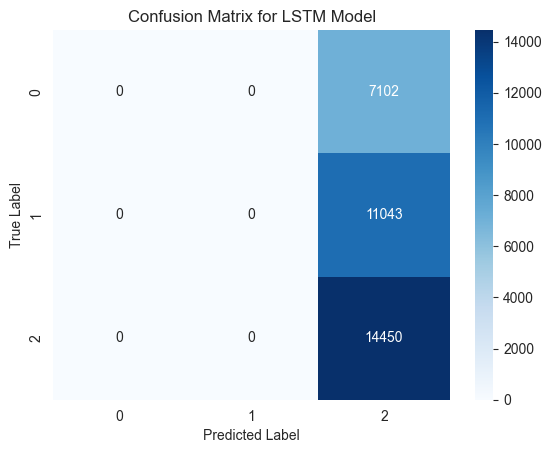

In [22]:
import os
import torch
import torch.nn as nn
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
model_save_path = "../models/"
lstm_model_path = os.path.join(model_save_path, "lstm_model.pth")
tokenizer_path = os.path.join(model_save_path, "tokenizer.pkl")
label_encoder_path = os.path.join(model_save_path, "label_encoder.pkl")

# Load the Tokenizer and Label Encoder
tokenizer = joblib.load(tokenizer_path)
label_encoder = joblib.load(label_encoder_path)

# Define the LSTM Model (should match the model architecture used for training)
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim=128, lstm_units=64, output_dim=3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, lstm_units, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(lstm_units * 2, 32)  # Bidirectional LSTM output is doubled
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Take output of last time step
        fc1_out = torch.relu(self.fc1(lstm_out))
        out = self.fc2(fc1_out)
        return out

# Load the trained LSTM model
vocab_size = len(tokenizer.word_index) + 1
output_dim = len(label_encoder.classes_)
lstm_model = LSTMClassifier(input_dim=vocab_size, output_dim=output_dim)
lstm_model.load_state_dict(torch.load(lstm_model_path))
lstm_model.eval()

# Load and preprocess the test data
def preprocess_test_data(X_test):
    # Tokenize and pad sequences
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_padded = torch.tensor(
        tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=100),
        dtype=torch.long
    )
    return X_test_padded

# Evaluation function
def evaluate_lstm_model(X_test, y_test):
    # Preprocess the test data
    X_test_padded = preprocess_test_data(X_test)
    y_test_encoded = label_encoder.transform(y_test)  # Ensure y_test is transformed as a class label vector (integers)

    # Create DataLoader for the test data
    test_dataset = TensorDataset(X_test_padded, torch.tensor(y_test_encoded, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Evaluate the model
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = lstm_model(sequences)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    # Convert predictions and labels to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Ensure labels are not in one-hot format
    if len(all_labels.shape) > 1 and all_labels.shape[1] > 1:
        all_labels = np.argmax(all_labels, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Print metrics
    print("\nLSTM Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix for LSTM Model")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Example Usage
# X_test and y_test should be loaded here. Assuming `X_test` and `y_test` are available as lists or pandas Series.
evaluate_lstm_model(X_test, y_test)


Some layers from the model checkpoint at ../models/distilbert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ../models/distilbert_model and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[DEBUG] Model loaded successfully from Hugging Face API.
1019/1019 [==============================] - 1919s 2s/step

DistilBERT Model Evaluation Metrics:
Accuracy: 0.9561
F1-score: 0.9557
Precision: 0.9573
Recall: 0.9561

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7102
           1       0.98      0.97      0.98     11043
           2       0.93      0.99      0.96     14450

    accuracy                           0.96     32595
   macro avg       0.96      0.94      0.95     32595
weighted avg       0.96      0.96      0.96     32595



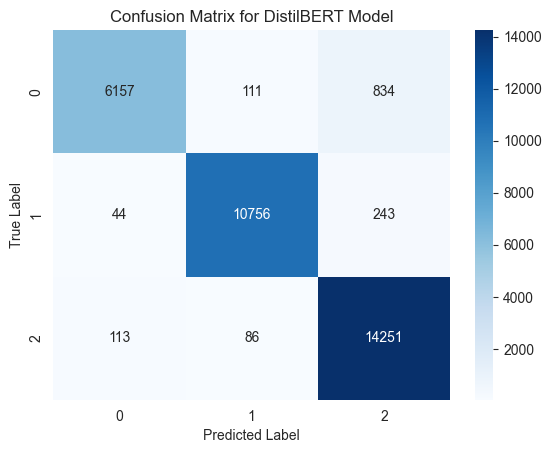

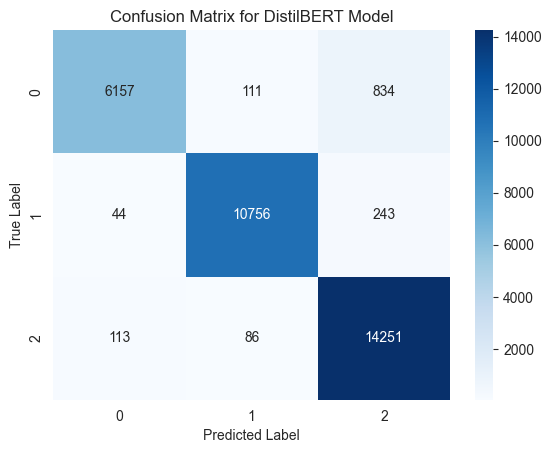

In [16]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

def evaluate_distilbert_model(X_test, y_test):
    """
    Function to load and evaluate the DistilBERT model.
    """
    # Define paths to the model directory, tokenizer, and label mapping files
    model_directory_path = os.path.join(model_save_path, "distilbert_model")
    label_mapping_path = os.path.join(model_save_path, "distilbert_label_mapping.pkl")

    # Check if required files are available
    if not all(os.path.exists(path) for path in [model_directory_path, label_mapping_path]):
        print("[ERROR] DistilBERT model or label mapping not found!")
        return

    # Load the DistilBERT model using the Hugging Face API
    try:
        distilbert_model = TFDistilBertForSequenceClassification.from_pretrained(model_directory_path)
        print("[DEBUG] Model loaded successfully from Hugging Face API.")
    except Exception as e:
        print(f"[ERROR] Failed to load model from Hugging Face API: {e}")
        return

    # Load tokenizer from the model directory
    tokenizer = DistilBertTokenizer.from_pretrained(model_directory_path)

    # Load label mapping
    label_mapping = joblib.load(label_mapping_path)

    # Encode the labels
    y_test_encoded = y_test.map(label_mapping).values

    # Preprocess test data using the tokenizer
    X_test_encodings = tokenizer(
        list(X_test),
        max_length=128,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )

    # Predict using the DistilBERT model
    try:
        y_probs = distilbert_model.predict(
            {"input_ids": X_test_encodings["input_ids"], "attention_mask": X_test_encodings["attention_mask"]}
        ).logits
        y_pred = np.argmax(y_probs, axis=1)
    except Exception as e:
        print(f"[ERROR] Error during prediction: {e}")
        return

    # Evaluate the model
    evaluate_model(y_test_encoded, y_pred, "DistilBERT Model")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix for DistilBERT Model")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Run the evaluation
evaluate_distilbert_model(X_test, y_test)
